In [1]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [2]:
from datetime import datetime, timedelta

import pandas as pd

current_date = pd.to_datetime(datetime.utcnow())
print(f"{current_date}")

2025-05-11 06:31:22.662472


In [3]:
type(current_date)

pandas._libs.tslibs.timestamps.Timestamp

In [4]:
from datetime import datetime, timedelta, timezone
current_date = pd.to_datetime(datetime.now(timezone.utc)).floor("h")

In [5]:
current_date.to_datetime64()

numpy.datetime64('2025-05-11T06:00:00.000000000')

In [6]:
fetch_data_to = current_date
fetch_data_from = current_date - timedelta(days=29)

In [7]:
fetch_data_to

Timestamp('2025-05-11 06:00:00+0000', tz='UTC')

In [8]:
from datetime import datetime, timedelta
from typing import Union
import pandas as pd
from src.data_utils import load_and_process_citibike_data

def fetch_batch_raw_data(from_date: Union[datetime, str], to_date: Union[datetime, str]) -> pd.DataFrame:
    """
    Simulate production data by sampling historical data from 52 weeks ago (i.e., 1 year).

    Args:
        from_date (datetime or str): The start date for the data batch.
        to_date (datetime or str): The end date for the data batch.

    Returns:
        pd.DataFrame: A DataFrame containing the simulated production data.
    """
    # Convert string inputs to datetime if necessary
    if isinstance(from_date, str):
        from_date = datetime.fromisoformat(from_date)
    if isinstance(to_date, str):
        to_date = datetime.fromisoformat(to_date)

    # Validate input dates
    if not isinstance(from_date, datetime) or not isinstance(to_date, datetime):
        raise ValueError("Both 'from_date' and 'to_date' must be datetime objects or valid ISO format strings.")
    if from_date >= to_date:
        raise ValueError("'from_date' must be earlier than 'to_date'.")

    # Shift dates back by 52 weeks (1 year) and strip timezones (make tz-naive)
    historical_from_date = (from_date - timedelta(weeks=52)).replace(tzinfo=None)
    historical_to_date = (to_date - timedelta(weeks=52)).replace(tzinfo=None)

    # Load and process historical data
    rides_from = load_and_process_citibike_data(year=historical_from_date.year, months=[historical_from_date.month])
    
    # Ensure pickup_datetime is tz-naive
    rides_from['pickup_datetime'] = pd.to_datetime(rides_from['pickup_datetime']).dt.tz_localize(None)
    rides_from = rides_from[rides_from.pickup_datetime >= historical_from_date]

    if historical_to_date.month != historical_from_date.month:
        rides_to = load_and_process_citibike_data(year=historical_to_date.year, months=[historical_to_date.month])
        rides_to['pickup_datetime'] = pd.to_datetime(rides_to['pickup_datetime']).dt.tz_localize(None)
        rides_to = rides_to[rides_to.pickup_datetime < historical_to_date]
        rides = pd.concat([rides_from, rides_to], ignore_index=True)
    else:
        rides = rides_from

    # Simulate new production timestamps
    rides['simulated_datetime'] = rides['pickup_datetime'] + timedelta(weeks=52)

    # Sort by location and datetime
    rides.sort_values(by=['pickup_location_id', 'pickup_datetime'], inplace=True)

    return rides


In [11]:
from src.data_utils import load_and_process_citibike_data_from_local, transform_raw_data_into_ts_data

In [12]:
# Step 1: Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import hopsworks
from hsfs.feature import Feature

from src.data_utils import load_and_process_citibike_data_from_local, transform_raw_data_into_ts_data


In [13]:
# Step 2: Load Data from Local
print("📂 Loading Citi Bike data (2023)...")
data = load_and_process_citibike_data_from_local(
    year=2023,
    months=[1,2,3,4,5,6],
    base_path=config.LOCAL_CITIBIKE_DATA_PATH
)

📂 Loading Citi Bike data (2023)...
2025-05-11 02:33:21,501 WARNING: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.

2025-05-11 02:33:24,989 WARNING: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.

2025-05-11 02:33:29,270 WARNING: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.

2025-05-11 02:33:32,238 WARNING: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.

2025-05-11 02:33:36,344 WARNING: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.

2025-05-11 02:33:39,686 WARNING: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.

2025-05-11 02:33:42,869 WARNING: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.

2025-05-11 02

In [14]:
print("✅ Loaded data shape:", data.shape)
display(data.head())

✅ Loaded data shape: (157285, 14)


ride_id  rideable_type         pickup_datetime  \
0  A46D077151843D7B   classic_bike 2023-01-16 10:39:54.386   
1  233875BAED2E02D0   classic_bike 2023-01-12 16:55:30.755   
2  8DD222EA1A1B0BC9  electric_bike 2023-01-08 19:32:25.647   
3  58976A4F584F8D28   classic_bike 2023-01-27 20:01:52.897   
4  FDD4C1E89A26727C   classic_bike 2023-01-13 18:02:38.160   

                  ended_at     start_station_name pickup_location_id  \
0  2023-01-16 10:45:18.005  West St & Chambers St            5329.03   
1  2023-01-12 17:04:03.688  West St & Chambers St            5329.03   
2  2023-01-08 19:42:00.382  West St & Chambers St            5329.03   
3  2023-01-27 20:08:58.118  West St & Chambers St            5329.03   
4  2023-01-13 18:11:22.139  West St & Chambers St            5329.03   

  end_station_name end_station_id  start_lat  start_lng    end_lat    end_lng  \
0   West Thames St        5114.06  40.717548 -74.013221  40.708347 -74.017134   
1   West Thames St        5114.06  40.717548 -74.013221  40.708347 -74.017134   
2   West Thames St        5114.06  40.717618 -74.013071  40.708347 -74.017134   
3   West Thames St        5114.06  40.717548 -74.013221  40.708347 -74.017134   
4   West Thames St        5114.06  40.717548 -74.013221  40.708347 -74.017134   

  member_casual                     source_file  
0        member  202301-citibike-tripdata_1.csv  
1        member  202301-citibike-tripdata_1.csv  
2        member  202301-citibike-tripdata_1.csv  
3        member  202301-citibike-tripdata_1.csv  
4        member  202301-citibike-tripdata_1.csv

In [15]:
# Step 3: Preprocess Data
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], errors="coerce")
data = data.dropna(subset=["pickup_datetime", "pickup_location_id"])
data["pickup_location_id"] = data["pickup_location_id"].astype(str)
data["pickup_hour"] = data["pickup_datetime"].dt.floor("h")

In [16]:
# Step 4: Transform into Hourly Time-Series
ts_data = transform_raw_data_into_ts_data(data)
print("✅ Transformed time-series shape:", ts_data.shape)
display(ts_data.head())

✅ Transformed time-series shape: (13287, 3)


pickup_hour pickup_location_id  rides
0 2022-12-28 11:00:00            5329.03      2
1 2022-12-28 12:00:00            5329.03      0
2 2022-12-28 13:00:00            5329.03      0
3 2022-12-28 14:00:00            5329.03      0
4 2022-12-28 15:00:00            5329.03      0

In [17]:
# Step 5: Check Aggregation Info
print("📅 Date range:", ts_data.pickup_hour.min(), "→", ts_data.pickup_hour.max())
print("🧠 Nulls present:")
display(ts_data.isnull().sum())

📅 Date range: 2022-12-28 11:00:00 → 2023-06-30 23:00:00
🧠 Nulls present:


pickup_hour           0
pickup_location_id    0
rides                 0
dtype: int64

2025-05-11 02:36:05,822 WARNING: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

2025-05-11 02:36:05,902 WARNING: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



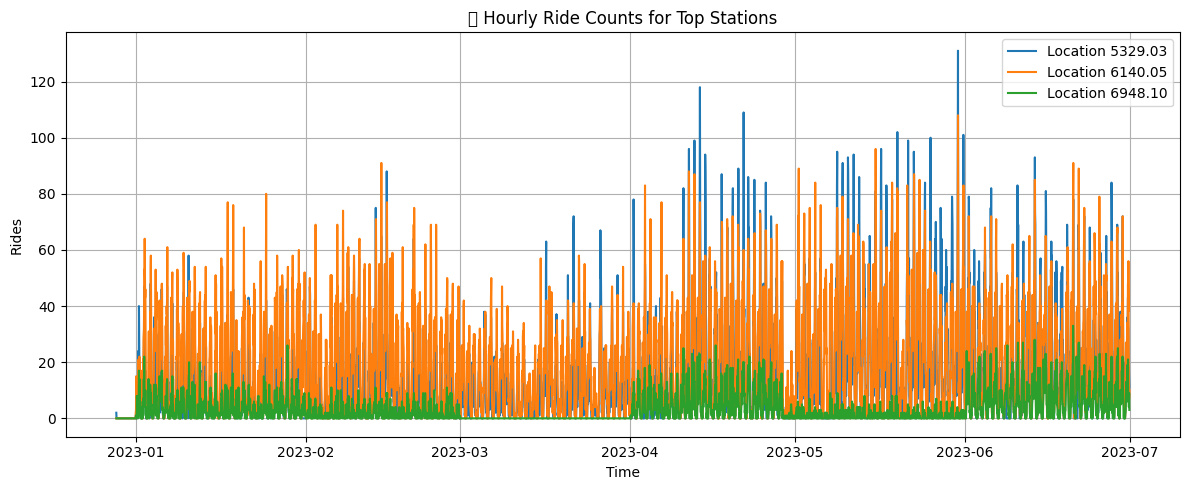

In [18]:
# Step 6: Visualize Time-Series
plt.figure(figsize=(12, 5))
for location_id in ts_data.pickup_location_id.unique():
    subset = ts_data[ts_data.pickup_location_id == location_id]
    plt.plot(subset.pickup_hour, subset.rides, label=f"Location {location_id}")
plt.legend()
plt.title("📈 Hourly Ride Counts for Top Stations")
plt.xlabel("Time")
plt.ylabel("Rides")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
csv_path = config.TRANSFORMED_DATA_DIR / "jan_jun_2023_ts_data.csv"
ts_data.to_csv(csv_path, index=False)
print(f"💾 Saved to: {csv_path}")

💾 Saved to: C:\Users\VAISHAK\OneDrive\Desktop\citibikenyc\data\transformed\jan_jun_2023_ts_data.csv


In [20]:
# Step 8: Connect to Hopsworks and Register Feature Group
print("🔐 Logging in to Hopsworks ...")
project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME,
    api_key_value=config.HOPSWORKS_API_KEY
)
fs = project.get_feature_store()

🔐 Logging in to Hopsworks ...
2025-05-11 02:36:24,187 INFO: Initializing external client
2025-05-11 02:36:24,188 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-11 02:36:25,111 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1228962


In [21]:
# Define schema and feature group
schema = [
    Feature("pickup_hour", "timestamp"),
    Feature("pickup_location_id", "string"),
    Feature("rides", "int")
]

fg = fs.get_or_create_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION,
    description="Hourly Citi Bike rides (March 2023)",
    primary_key=["pickup_hour", "pickup_location_id"],
    event_time="pickup_hour",
    online_enabled=False,
    features=schema
)


In [22]:
# Cast dtypes and insert
print("📤 Writing to Hopsworks...")
ts_data["pickup_location_id"] = ts_data["pickup_location_id"].astype(str)
ts_data["rides"] = ts_data["rides"].astype("int64")
fg.insert(ts_data, write_options={"wait_for_job": True})
print("✅ Successfully registered with Hopsworks")


📤 Writing to Hopsworks...


Uploading Dataframe: 100.00% |██████████| Rows 13287/13287 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: citibike_hourly_features_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1228962/jobs/named/citibike_hourly_features_1_offline_fg_materialization/executions
2025-05-11 02:36:46,873 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-05-11 02:36:49,988 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-05-11 02:39:06,740 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-05-11 02:39:06,814 INFO: Waiting for log aggregation to finish.
2025-05-11 02:39:18,262 INFO: Execution finished successfully.
✅ Successfully registered with Hopsworks
